A notebook for visualising the SNMR data for SSC.

neil Symington


In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import shapely
import os
from shapely.geometry import Point
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from hydrogeol_utils import SNMR_utils, spatial_functions, AEM_utils
from hydrogeol_utils import plotting_utils as plot_utils
from sqlalchemy import create_engine, event

In [5]:
# Connect to the SNMR database

DB_PATH = r"C:\Users\PCUser\Desktop\SSC_data\SNMR\SSC_SNMR.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

query = """

SELECT
              s.site_id,
              s.Field_ID,
              s.mid_X,
              s.mid_Y,
              a.acquisition_id,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.pulse_sequence == "FID"
"""

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Only sites from Tennant Creek

#df_acquisitions = df_acquisitions[df_acquisitions['Field_ID'].str.startswith('TC')]

df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = ['FID'],
                                 pulse_length_criteria="min")]

# Now extract the SNMR inversions

acquisition_ids = df_acquisitions.index

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id']

df_SNMR_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = False)[cols]


# Join the SNMR inversions on acquisition and sites

df_SNMR_inversions = df_SNMR_inversions.merge(df_acquisitions, how='inner', left_on='acquisition_id',
                                    right_index=True, )

In [7]:
df_SNMR_inversions.to_csv(r"C:\Temp\SSC_SNMR.csv")

In [66]:
def plot_profile(ax, df, doi= None, plot_mobile_water = False,
                 water_table_depth = None):
    """
    Function for plotting SNMR profiles similarly to the GMR inversion
    software. This function allows customised plots and importantly
    the ability to include the doi.

    :param ax: matplotlib axis
    :param df: individual inversion dataframe
    :param doi: depth of investigation
    :param plot_mobile_water: boolean flag for plotting mobile water
    mobile water
    :param water_table_depth float of water table depth to be plotted
    :return:
    matplotlib axis with profile plotted
    """

    # define plot data using pandas series names
    y = df['Depth_from'].values
    Total = df['Total_water_content'].values * 100

    if plot_mobile_water:
        Mobile = df['Mobile_water_content'].values * 100
        # Plot the data
        ax.fill_betweenx(y, 0, Total,
                         label='Bound H2O', facecolor='pink')
        ax.fill_betweenx(y, 0, Mobile,
                         label='Mobile H2O', facecolor='blue')
    else:
        ax.fill_betweenx(y, 0, Total,
                         label='Mobile H2O', facecolor='blue')


    # set the range on the x axis so all the plots are the same scale
    ax.set_xlim([0, np.max(Total) + 5])


    # plot lines
    ax.plot(Total, y, 'k-', linewidth=0.5)

    if plot_mobile_water:
        ax.plot(Mobile, y, 'k-', linewidth=0.5)
    else:
        ax.plot(Total, y, 'k-', linewidth=0.5)


    # define axis names
    ax.set_ylabel('Depth m')
    ax.set_xlabel('Water content %')

    # Add the depth of investigation if provided

    if doi is not None:

        ax.hlines(doi, ax.get_xlim()[0], ax.get_xlim()[1],
                  color='green', linestyles='dotted',
                 label = 'depth of investigation')

        # make legend
    ax.legend(fontsize=10)
    ax.set_ylim(0, doi + 10.)
    return ax


In [67]:
df_SNMR_inversions['inversion_id'].unique()

array([88, 89, 91, 93, 94, 96, 97], dtype=int64)

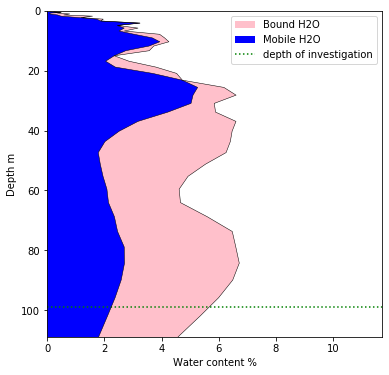

In [69]:
# Finally lets plot an inversion

fig, ax1 = plt.subplots(1,1, sharey=True, figsize = (6,6))

inv_id = 94

df_site_inv = df_SNMR_inversions[df_SNMR_inversions['inversion_id'] == inv_id]


ax1 = plot_profile(ax1, df_site_inv, doi = df_site_inv['Depth_of_Investigation'].iloc[0],
                  plot_mobile_water = True)
ax1.set_title('')

plt.gca().invert_yaxis()
plt.savefig(r"C:\temp\SNMR_example_fig.png", dpi = 300)
plt.show()

In [54]:
df_SNMR_inversions['']

,Depth_from,Depth_to,Mobile_water_content,Bound_water_content,Total_water_content,T2*,acquisition_id,inversion_id,site_id,Field_ID,mid_X,mid_Y,pulse_sequence,pulse_length,Depth_of_Investigation
table_id,,,,,,,,,,,,,,,
4400,0.414881,0.596031,0.001481,0.000000,0.001481,0.721184,89,88,57,TC_GMR_25,407819.4942,7806828.56,FID,80.0,92.802041
4401,0.596031,0.823463,0.011238,0.000000,0.011238,0.156578,89,88,57,TC_GMR_25,407819.4942,7806828.56,FID,80.0,92.802041
4402,0.823463,1.102440,0.005823,0.000000,0.005823,0.445842,89,88,57,TC_GMR_25,407819.4942,7806828.56,FID,80.0,92.802041
4403,1.102440,1.438227,0.007947,0.000000,0.007947,0.133102,89,88,57,TC_GMR_25,407819.4942,7806828.56,FID,80.0,92.802041
4404,1.438227,1.836089,0.000000,0.001381,0.001381,2.606037,89,88,57,TC_GMR_25,407819.4942,7806828.56,FID,80.0,92.802041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,129.093180,136.569200,0.002629,0.009327,0.011956,0.105021,98,97,63,TC_GMR_18,381027.6859,7818890.07,FID,80.0,92.802041
4896,136.569200,144.328410,0.002120,0.007457,0.009577,0.106000,98,97,63,TC_GMR_18,381027.6859,7818890.07,FID,80.0,92.802041
4897,144.328410,152.376090,0.001702,0.005931,0.007633,0.106614,98,97,63,TC_GMR_18,381027.6859,7818890.07,FID,80.0,92.802041
